In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import pickle
sns.set_style('dark')

## Downloading the datasets

In [2]:
bruker = pd.read_csv('cleandata/bruker.csv')

rangering = pd.read_csv('cleandata/rangering.csv')

film = pd.read_csv('cleandata/film.csv')

### Making the datasets easier to use later

Here I will drop some of the columns in our datasets. The columns Postkode and Jobb in bruker will not be used later since I look at those values as somewhat irrelevant for predicting movies. The column Tidstempel will also be droped from the rangering dataframe by the same reason. 

Finally I will combine the remaning DataFrames such that I get an combined DataFrame to use later.

In [3]:
# Drops unneeded columns
bruker = bruker.drop(['Postkode', 'Jobb'], axis=1) 
rangering = rangering.drop('Tidstempel', axis=1)

# Making a combined DataFrame
data = pd.merge(rangering, film, on='FilmID')

## Plots

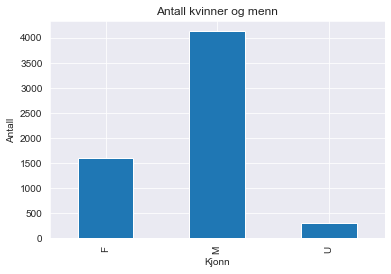

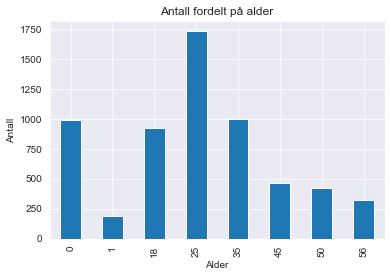

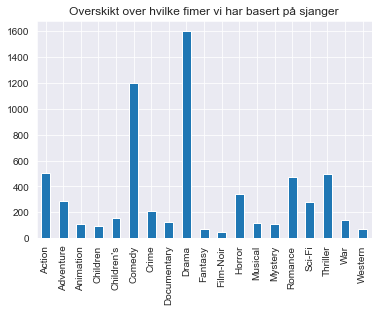

In [4]:
bruker.groupby('Kjonn').count()['BrukerID'].plot.bar()
plt.grid()
plt.title('Antall kvinner og menn')
plt.ylabel('Antall')
plt.show()

bruker.groupby('Alder').count()['BrukerID'].plot.bar()
plt.grid()
plt.title('Antall fordelt på alder')
plt.ylabel('Antall')
plt.show()

film.drop(columns=['FilmID','Tittel']).sum().plot.bar()
plt.grid()
plt.title('Overskikt over hvilke fimer vi har basert på sjanger')
plt.show()

Over I have made three plots. The first is a plot of how many females and how many males we have in our dataset. As one can see we have a signifficantly higher number of males than females and unknowns. That we have a low number of unknown is a good thing. When I will make the models I will not use wheter the user is a man or woman but it is good to notice this skewness anyhow. This may imply that we can make predictions better for males then females, given that we think there are differences in which movies males and females likes.

The second plot is a plot over how old the people in the dataset are. Again, I will not use this data when making the models but it is worth noticing just like with the gender distribution. We can see that we have the majority in the range from 18-45. This implies that the models migth predict better for people in this age group than for people in another age group. This is only true if there are differences in which movie each age group like.

In the third plot we have the distribution of number of movies given each genre. Here we can see that the genres Drama, Comedy and Action is a lot higher than the rest. 

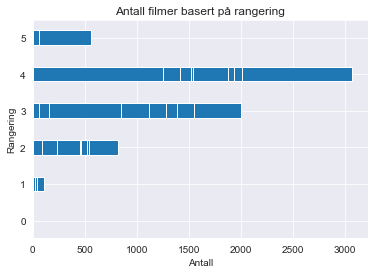

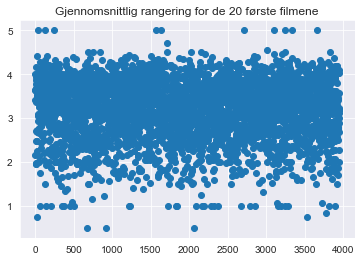

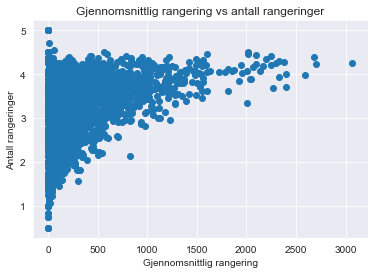

In [5]:
movies = pd.DataFrame(data.groupby('FilmID')['Rangering'].mean())
movies['Antall rangeringer'] = pd.DataFrame(data.groupby('FilmID')['Rangering'].count())


plt.barh(movies['Rangering'].round(),movies['Antall rangeringer'],height=0.4)
plt.grid()
plt.title('Antall filmer basert på rangering')
plt.ylabel('Rangering')
plt.xlabel('Antall')
plt.show()

plt.scatter(movies.index, movies['Rangering'])
plt.title('Gjennomsnittlig rangering for de 20 første filmene')
plt.grid()
plt.show()

plt.scatter(movies['Antall rangeringer'], movies['Rangering'])
plt.grid()
plt.title('Gjennomsnittlig rangering vs antall rangeringer')
plt.ylabel('Antall rangeringer')
plt.xlabel('Gjennomsnittlig rangering')
plt.show()

Over I have ploted some information about the ratings in our dataset. The first plot is a plot over the number of movies we have for each rating, here the numbers found by taking the mean rating for each movie and than rounded to the nearest integer. As expected we have the majority of rating averages in the range 3-5 with most ratings at 4. 

The second plot is a plot over the mean ratings for each movie. This plot is for checking that we do not have any unwanted values, like for example negative values. Which we do not.

The third and final plot is a plot over the mean ratings for each movie vs how many ratings that movie has. I prsonaly think this is the most interresting plot. Here we can see that if a movie has over 1000 ratings than it will have an average rating of, mostly, over 3.5. What this plots shows us is that for a lot of movies we have to few ratings. More ratings will gives us a more information about what kind of person likes what kind of movie.

## Feature engeneering
Here I will do some feature engeneering partley based on the information given to us by the plots above. I will combine the romance and drama columns such that we look at these genres as the same from now on. I will also combine the genres thriller and action. My final feature engeneering will be to count the number of letters in each movie title. The reason for combining the columns drama and romance and action and thriller is that I see those genres as similar. 

In [6]:
# Combine romance and drama
romance_drama = []
for i in range(len(data['Drama'])):
    if data['Drama'][i] == 1:
        romance_drama.append(1)
    elif data['Romance'][i] == 1:
        romance_drama.append(1)
    else:
        romance_drama.append(0)

# Add the new feature and remove the old ones
data['Romance/Drama'] = romance_drama
data = data.drop(['Drama', 'Romance'], axis = 1)


# Combine action and thriller
action_thriller = []
for i in range(len(data['Action'])):
    if data['Action'][i] == 1:
        action_thriller.append(1)
    elif data['Thriller'][i] == 1:
        action_thriller.append(1)
    else:
        action_thriller.append(0)

# Add the new feature and remove the old ones
data['Action/Thriller'] = action_thriller
data = data.drop(['Action', 'Thriller'], axis = 1)


# Add the length of each movie title
length_title = []
for i in range(len(data['Tittel'])):
    length_title.append(len(data['Tittel'][i])-7)
    
data['Tittel lengde'] = length_title
data = data.drop(['Tittel'], axis = 1)


print(data)

# Add the merged and engeneered data to the cleandata file
data.to_csv('cleandata/data.csv', index=False)

        BrukerID  FilmID  Rangering  Adventure  Animation  Children  \
0              0     616        2.0          0          0         0   
1             28     616        2.5          0          0         0   
2             91     616        0.5          0          0         0   
3            101     616        1.5          0          0         0   
4            126     616        3.0          0          0         0   
...          ...     ...        ...        ...        ...       ...   
898691      5835      39        4.0          0          0         0   
898692      5835    1358        4.0          0          0         0   
898693      5846    1788        4.0          0          0         0   
898694      5888     951        3.0          0          0         0   
898695      6004    1038        3.0          0          0         0   

        Children's  Comedy  Crime  Documentary  ...  Film-Noir  Horror  \
0                0       0      0            0  ...          0       1   

In [7]:
# Doing the same for the file film
film2 = film.copy()
# Combine romance and drama
romance_drama = []
for i in range(len(film['Drama'])):
    if film['Drama'][i] == 1:
        romance_drama.append(1)
    elif film['Romance'][i] == 1:
        romance_drama.append(1)
    else:
        romance_drama.append(0)

# Add the new feature and remove the old ones
film2['Romance/Drama'] = romance_drama
film2 = film2.drop(['Drama', 'Romance'], axis = 1)


# Combine action and thriller
action_thriller = []
for i in range(len(film['Action'])):
    if film2['Action'][i] == 1:
        action_thriller.append(1)
    elif film2['Thriller'][i] == 1:
        action_thriller.append(1)
    else:
        action_thriller.append(0)

# Add the new feature and remove the old ones
film2['Action/Thriller'] = action_thriller
film2 = film2.drop(['Action', 'Thriller'], axis = 1)


# Add the length of each movie title
length_title = []
for i in range(len(film['Tittel'])):
    length_title.append(len(film['Tittel'][i])-7)
    
film2['Tittel lengde'] = length_title
film2 = film2.drop(['Tittel'], axis = 1)


print(film)

# Add the merged and engeneered data to the cleandata file
film2.to_csv('cleandata/film2.csv', index=False)

      FilmID                                    Tittel  Action  Adventure  \
0          0                 Autumn in New York (2000)       0          0   
1          1  Vie est belle, La (Life is Rosey) (1987)       0          0   
2          2                    Defying Gravity (1997)       0          0   
3          3                    Ruthless People (1986)       0          0   
4          4                  Portraits Chinois (1996)       0          0   
...      ...                                       ...     ...        ...   
3878    3948                         Cat People (1982)       0          0   
3879    3949              Saltmen of Tibet, The (1997)       0          0   
3880    3950               Bride of Re-Animator (1990)       0          0   
3881    3951                          True Lies (1994)       1          1   
3882    3952                         Prom Night (1980)       0          0   

      Animation  Children  Children's  Comedy  Crime  Documentary  ...  \
0

## Making the train, val and test data

In [8]:
Train, Val_Test = train_test_split(data, test_size=0.3, random_state=11)
Val, Test = train_test_split(Val_Test, test_size=0.5, random_state=11)

X_val = Val[['BrukerID', 'FilmID']]
y_val = Val['Rangering']

X_test = Test[['BrukerID', 'FilmID']]
y_test = Test['Rangering']


Train.to_csv('cleandata/Train.csv', index=False)
X_val.to_csv('cleandata/X_val.csv', index=False)
X_test.to_csv('cleandata/X_test.csv', index=False)
y_val.to_csv('cleandata/y_val.csv', index=False)
y_test.to_csv('cleandata/y_test.csv', index=False)

## Making the baseline model

This model will stores the mean ratings from all users for each movie in the training set.

In [9]:
def baseline_model():
    mean_ratings = pd.DataFrame(Train.groupby('FilmID')['Rangering'].mean())
    return mean_ratings

model_baseline = baseline_model()

pickle.dump(model_baseline, open('model_baseline.pkl', 'wb'))

## Making the content based model

This model will take the BrukerID and store all the ratings given by this user. The ratings will be the y values and the movie genres will be the X values. I have decided to go for a k neares neighboor aproch. For each BrukerID I will have a knn model and store that model in a dictionary with the BrukerID as the key. After a lot of trying I ended up with n = 5, which gives me the best results. This makes sense since if n is big then our predictions will just be an average, we are interrested in just the most similar movies.

In [10]:

from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1)
def content_based(userid):
    X_train = Train.loc[Train['BrukerID'] == userid].drop(['BrukerID', 'Rangering', 'FilmID'], axis=1)
    y_train = Train.loc[Train['BrukerID'] == userid]['Rangering']

    lasso.fit(X_train, y_train)
    return lasso

model_cb = {}
for i in Train['BrukerID'].unique():
    model_cb[i] = content_based(i)
    
pickle.dump(model_cb, open('model_cb.pkl', 'wb'))


C:\Users\marcu\Documents\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


## Making the collaborative model

For this model I have decided to go for the same aproch as in the lecture on recommender systems. Here I will make a correlation matrix which gives us the correlation between user i, index value, and user j, column value, by how they have rated movies.

In [11]:
# Make a table consisting of BrukerID as index, FilmID as columns and the given ratings from each BrukerID to each FilmID
table = pd.pivot_table(Train, values='Rangering', columns='FilmID', index='BrukerID')

# Stores a list of all the BrukerID mean ratings
bruker_mean = table.mean(axis=1)

# Fill the table with 0.1 instead of NaN
table = table.fillna(0.1)

# Transpose the table such that we get FilmID as indexes and BrukerID as columns, this makes the naxt step easier
table = table.transpose()

# Replace every none rated movie by the mean ratings for each BrukerID
for i in table.columns:
    table[i] = table[i].replace([0.1], bruker_mean[i])

# Transpose back
table = table.transpose()

# Stores all the index names as a list
idx = list(table.index)

# Makes a correlation matrix 
correlation_matrix = pd.DataFrame(np.corrcoef(table))

correlation_matrix.index = idx
correlation_matrix.columns = idx

C:\Users\marcu\Documents\Anaconda\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\marcu\Documents\Anaconda\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [12]:
print(correlation_matrix)

pickle.dump(correlation_matrix, open('correlation_matrix.pkl', 'wb'))

              0             1             2             3             4     \
0     1.000000e+00 -2.131090e-25  1.147962e-02  1.123028e-01  1.444190e-02   
1    -2.131090e-25  1.000000e+00  7.274630e-03  2.251241e-24 -2.309960e-02   
2     1.147962e-02  7.274630e-03  1.000000e+00  1.565287e-23  6.060056e-02   
3     1.123028e-01  2.251241e-24  1.565287e-23  1.000000e+00 -7.459279e-24   
4     1.444190e-02 -2.309960e-02  6.060056e-02 -7.459279e-24  1.000000e+00   
...            ...           ...           ...           ...           ...   
6036 -1.470190e-02  4.470686e-25  1.558418e-02  1.016146e-23  7.366227e-02   
6037 -1.633996e-02  8.853195e-25 -4.707793e-02  4.851012e-04  8.043627e-02   
6038  1.125666e-02 -4.096814e-25 -2.848502e-24 -7.764743e-03 -8.865132e-02   
6039  4.696645e-02  7.985701e-03 -3.547340e-03 -2.420970e-23  9.868444e-03   
6040  1.933395e-02 -9.793788e-03  2.468816e-02  9.341185e-24  6.928910e-03   

          5             6             7         8         9    

## Combined approch

For the combined approch I will take a weighted average of the content based and collaborative model. Here we do not have to make any model since both models are made earlier.